In [22]:
import datetime as dt
import pandas as pd
import  plotly.express as px 
import plotly.graph_objects as go

#Read US Covid deaths abd filter LA county 
US_Deaths_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
US_Deaths_df = pd.read_csv(US_Deaths_url, error_bad_lines=True)
US_Deaths_df=US_Deaths_df.drop(columns=['UID','iso2','iso3','code3','Admin2', 'Country_Region','Lat','Long_','Combined_Key'])
US_Deaths_df=US_Deaths_df.dropna(subset=['FIPS'])
US_Deaths_df=US_Deaths_df.melt(id_vars=["FIPS","Population","Province_State"], 
        var_name="Date", 
        value_name="Value")

#Read US Covid cases
Confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
US_Cases_df = pd.read_csv(Confirmed_url, error_bad_lines=True)
US_Cases_df=US_Cases_df.drop(columns=['UID','iso2','iso3','code3','Admin2', 'Province_State', 'Country_Region','Lat','Long_','Combined_Key'])
US_Cases_df=US_Cases_df.dropna(subset=['FIPS'])
US_Cases_df=US_Cases_df.melt(id_vars=['FIPS'], 
        var_name="Date", 
        value_name="Value")


US_Deaths_df.iloc[:, 3] = pd.to_datetime(US_Deaths_df.iloc[:, 3])
US_Deaths_df.iloc[:, 3]  = (US_Deaths_df.iloc[:, 3]  - US_Deaths_df['Date'].iloc[0]).dt.days
US_Deaths_df = US_Deaths_df.rename(columns={'Date': 'Days', 'Value':'Cumulative_Deaths' })

#US_Deaths_df['Weekly_Deaths'] = US_Deaths_df.groupby(['FIPS', 'Week'])['Cumulative_Deaths'].transform(lambda x: (x.iat[-1] - x.iat[0]))
US_Deaths_df['Weekly_Deaths'] = 0
US_Deaths_df['Weekly_Deaths_Per'] = 0.0
US_Deaths_df['Past_Week_Cumulative_Deaths'] = 0
US_Deaths_df = US_Deaths_df.reset_index()
US_Deaths_df.sort_values(by=['FIPS','Days'], inplace=True)
cdArray = US_Deaths_df['Cumulative_Deaths'].to_numpy()
fipsArray = US_Deaths_df['FIPS'].to_numpy()
i = 0
j = 0
FIPS = 0.0
for index, row in US_Deaths_df.iterrows():
  countyFIPS = row['FIPS']
  if FIPS == countyFIPS: 
    if j > 6 and fipsArray[i-7] == countyFIPS :
        previous_cum_deaths = cdArray[i-7]
        weekly_deaths = row['Cumulative_Deaths'] - previous_cum_deaths
        US_Deaths_df.at[index,'Weekly_Deaths'] =  weekly_deaths
        if previous_cum_deaths  == 0:
          previous_cum_deaths = 1
        US_Deaths_df.at[index, 'Past_Week_Cumulative_Deaths'] = previous_cum_deaths
        US_Deaths_df.at[index, 'Weekly_Deaths_Per'] = (weekly_deaths  * 100) / (previous_cum_deaths * 1.0)
  else:
    FIPS = countyFIPS
    j = 0 
    US_Deaths_df.at[index,'Weekly_Deaths'] = 0
  i = i + 1
  j = j + 1
 
US_Cases_df.iloc[:, 1] = pd.to_datetime(US_Cases_df.iloc[:, 1])
US_Cases_df.iloc[:, 1]  = (US_Cases_df.iloc[:, 1]  - US_Cases_df['Date'].iloc[0]).dt.days
US_Cases_df = US_Cases_df.rename(columns={'Date': 'Days', 'Value':'Cumulative_Cases'})
US_Cases_df['Weekly_Cases'] = 0
US_Cases_df['Weekly_Cases_Per'] = 0.0
US_Cases_df = US_Cases_df.reset_index()
US_Cases_df.sort_values(by=['FIPS','Days'], inplace=True)
cdArray = US_Cases_df['Cumulative_Cases'].to_numpy()
fipsArray = US_Cases_df['FIPS'].to_numpy()
i = 0
j = 0
for index, row in US_Cases_df.iterrows():
  countyFIPS = row['FIPS']
  if FIPS == countyFIPS: 
    if j > 6 and fipsArray[i-7] == countyFIPS :
        previous_cum_cases = cdArray[i-7]
        weekly_cases = row['Cumulative_Cases'] - previous_cum_cases
        US_Cases_df.at[index,'Weekly_Cases'] =  weekly_cases
        if previous_cum_cases  == 0:
          previous_cum_cases = 1
        US_Cases_df.at[index, 'Weekly_Cases_Per'] = (weekly_cases * 100.0) / (previous_cum_cases * 1.0)
  else:
    FIPS = countyFIPS
    j = 0
    US_Cases_df.at[index,'Weekly_Cases'] = 0
  i = i + 1
  j = j + 1
 
US_Cases_df["Days"] = US_Cases_df["Days"] + 7
US_Deaths_df.to_csv("us_deaths",index = False)

In [23]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

In [24]:
#load state tests data to combine with cases and deaths
#data is not available for all days, populate zero for missing ones
from datetime import timedelta, date

state_codes = pd.read_csv('https://docs.google.com/spreadsheets/d/1DAqxIYJdagFN85ncoTQO-CbpJLQECvZWt6qwNMQZUkk/export?format=csv')
start_date = date(2020, 1, 22)
end_date = date.today()

state_codes_date_df = pd.DataFrame({'Date': pd.Series([], dtype='str'),
                   'Code': pd.Series([], dtype='str'),
                   'State': pd.Series([], dtype='str')})
for single_date in daterange(start_date, end_date):
  for index, row in state_codes.iterrows():
    state_codes_date_df = state_codes_date_df.append({'Date': single_date.strftime("%Y%m%d"), 'Code' : row["Code"], 'State' : row["State"]}, ignore_index=True)
state_tests = pd.read_csv("https://covidtracking.com/api/v1/states/daily.csv")
convert_dict = {'date': str} 
state_tests = state_tests.astype(convert_dict)
state_tests_df = state_codes_date_df.merge(state_tests[['date','state','positive', 'negative']],how='left', left_on=['Date', 'Code'], right_on=['date', 'state'])
state_tests_df.sort_values(['Date','State'], inplace=True)
state_tests_df.iloc[:, 0] = pd.to_datetime(state_tests_df.iloc[:, 0],format="%Y%m%d")
state_tests_df.iloc[:, 0]  = (state_tests_df.iloc[:, 0] - state_tests_df['Date'].iloc[0]).dt.days
state_tests_df = state_tests_df.rename(columns={'Date': 'Days'})
state_tests_df['Cumulative_Tests'] = state_tests_df['positive'] + state_tests_df ['negative']
state_tests_df = state_tests_df.drop(columns=['date', 'state', 'positive', 'negative'])
state_tests_df.fillna(0, inplace=True)

In [25]:
#Read county variates dataset and combine with FIPS, race, icu_beds dataset
county_covariates= pd.read_csv('https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/counties.csv').dropna(subset=['FIPS'])
county_covariates.FIPS = county_covariates.FIPS.astype('int64')
county_covariates=county_covariates.set_index('FIPS')
age_race_df = pd.read_csv('https://docs.google.com/spreadsheets/d/12GIRONjeNHeKFb3EKpo5r-VvdsnTwwe0iOtKBsnZVM0/export?format=csv')
county_icu_beds= pd.read_csv('https://docs.google.com/spreadsheets/d/13iUBUwRcE91_x9FhsF8Ugcb0_tFauWJF2Z-PSkERDlU/export?format=csv')
FIPS = pd.read_csv('https://docs.google.com/spreadsheets/d/1jUwRaTSJ__3Wp60cZLLox5u55mJTZrShtjEK4d7xTEY/export?format=csv')
covariates = age_race_df.merge(county_covariates, how='inner', left_on=["fips"], right_on=['FIPS'])
covariates = covariates.drop(['STNAME', 'County', 'Unnamed: 0','State', 'Area_Name'], axis=1)
covariates = covariates.merge(county_icu_beds, how='inner', left_on=["fips"], right_on=['fips'])
covariates = covariates.drop(['County','State'], axis=1)
#dropping full NaN counties
covariates = covariates[covariates['Jul Temp Max / F'].notnull()]
#merge with US FIPS and makue  sure FIPS are only in the US
US_Deaths_df = US_Deaths_df.merge(FIPS,how='inner', left_on=["FIPS"], right_on=['fips'])
US_Cases_df = US_Cases_df.merge(FIPS,how='inner', left_on=["FIPS"], right_on=['fips'])
list(covariates.columns) 
covariates = covariates.dropna(axis='columns')
list(covariates.columns) 

covariates=covariates[['fips',
 'TOT_POP',
 '0-9',
 '0-9 y/o % of total pop',
 '10-19',
 '10-19 y/o % of total pop',
 '20-29',
 '20-29 y/o % of total pop',
 '30-39',
 '30-39 y/o % of total pop',
 '40-49',
 '40-49 y/o % of total pop',
 '50-59',
 '50-59 y/o % of total pop',
 '60-69',
 '60-69 y/o % of total pop',
 '70-79',
 '70-79 y/o % of total pop',
 '80+',
 '80+ y/o % of total pop',
 'White-alone pop',
 '% White-alone',
 'Black-alone pop',
 '% Black-alone',
 'Native American/American Indian-alone pop',
 '% NA/AI-alone',
 'Asian-alone pop',
 '% Asian-alone',
 'Hawaiian/Pacific Islander-alone pop',
 '% Hawaiian/PI-alone',
 'Two or more races pop',
 '% Two or more races',
 'POP_ESTIMATE_2018',
 'N_POP_CHG_2018',
 'GQ_ESTIMATES_2018',
 'R_birth_2018',
 'R_death_2018',
 'R_NATURAL_INC_2018',
 'R_INTERNATIONAL_MIG_2018',
 'R_DOMESTIC_MIG_2018',
 'R_NET_MIG_2018',
 'Less than a high school diploma 2014-18',
 'High school diploma only 2014-18',
 "Some college or associate's degree 2014-18",
 "Bachelor's degree or higher 2014-18",
 'Percent of adults with less than a high school diploma 2014-18',
 'Percent of adults with a high school diploma only 2014-18',
 "Percent of adults completing some college or associate's degree 2014-18",
 "Percent of adults with a bachelor's degree or higher 2014-18",
 'POVALL_2018',
 'PCTPOVALL_2018',
 'PCTPOV017_2018',
 'PCTPOV517_2018',
 'MEDHHINC_2018',
 'CI90LBINC_2018',
 'CI90UBINC_2018',
 'Civilian_labor_force_2018',
 'Employed_2018',
 'Unemployed_2018',
 'Unemployment_rate_2018',
 'Median_Household_Income_2018',
 'Med_HH_Income_Percent_of_State_Total_2018',
 'Jan Precipitation / inch',
 'Feb Precipitation / inch',
 'Mar Precipitation / inch',
 'Apr Precipitation / inch',
 'May Precipitation / inch',
 'Jun Precipitation / inch',
 'Jul Precipitation / inch',
 'Jan Temp AVG / F',
 'Feb Temp AVG / F',
 'Mar Temp AVG / F',
 'Apr Temp AVG / F',
 'May Temp AVG / F',
 'Jun Temp AVG / F',
 'Jul Temp AVG / F',
 'Active Physicians per 100000 Population 2018 (AAMC)',
 'Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)',
 'Active Primary Care Physicians per 100000 Population 2018 (AAMC)',
 'Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)',
 'Active General Surgeons per 100000 Population 2018 (AAMC)',
 'Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)',
 'Total nurse practitioners (2019)',
 'Total physician assistants (2019)',
 'Total Hospitals (2019)',
 'Internal Medicine Primary Care (2019)',
 'Family Medicine/General Practice Primary Care (2019)',
 'Total Specialist Physicians (2019)',
 'ICU Beds_x',
 'Total Population',
 'Population Aged 60+',
 'Percent of Population Aged 60+']]
 
#print(covariates)

In [26]:
#merge us covid deaths and cases with covariates

US_Deaths_Cases_df = US_Deaths_df.merge(US_Cases_df[['Cumulative_Cases', 'Weekly_Cases', 'FIPS', 'Days']], how='inner', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(state_tests_df, how='inner', left_on=['Province_State', "Days"], right_on=['State', 'Days'])
covariates_merged = covariates.merge(US_Deaths_Cases_df[['Cumulative_Tests','Cumulative_Cases', 'Weekly_Cases', 'FIPS', 'Days']], how='inner', left_on=["fips"], right_on=['FIPS'])
#dropping NaN columns
covariate_merged = covariates_merged.dropna(axis='columns')
US_Deaths_Cases_df =  US_Deaths_Cases_df.dropna(axis='columns')
fips_state=age_race_df[['STNAME','fips']]
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(fips_state, how='inner', left_on=["FIPS"], right_on=['fips'])
US_Deaths_Cases_df = US_Deaths_Cases_df.drop(columns=['index'])
#pd.set_option('display.max_rows', None)
#corr=covariate_merged.corr()
#print(corr[['Cumulative_Deaths','Daily_Deaths']])

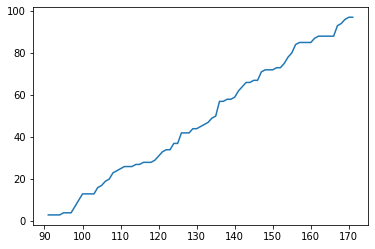

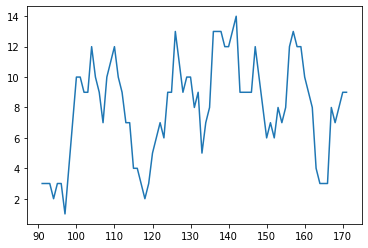

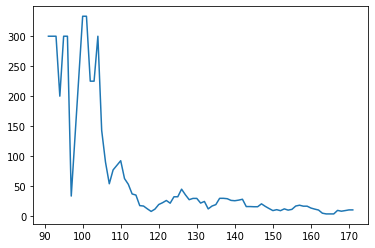

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
US_Deaths_Cases_df
Deaths_Cases_df = US_Deaths_Cases_df[(US_Deaths_Cases_df["FIPS"] == 4015.0) & (US_Deaths_Cases_df["Days"] > 90)]

x = Deaths_Cases_df["Days"]
y = Deaths_Cases_df["Cumulative_Deaths"]
plt.plot(x, y)
plt.show()

y = Deaths_Cases_df["Weekly_Deaths"]

plt.plot(x, y)
plt.show()
y = Deaths_Cases_df["Weekly_Deaths_Per"]
plt.plot(x, y)
plt.show()


In [28]:
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
import xgboost as xgb
from datetime import datetime

warnings.filterwarnings("ignore", category=ConvergenceWarning)
covid_start_date = datetime.strptime("01/22/20", "%m/%d/%y")

min_day=US_Deaths_Cases_df['Days'].min()
max_day=US_Deaths_Cases_df['Days'].max()
countyFIPS = US_Deaths_Cases_df["FIPS"].unique()

num_weeks=int((max_day-min_day)/7)
print("number of weeks : " , num_weeks)
#prediction_days_arr = [7,14,21,28]
#prediction_days = 7   # one week  train , tune and forecast
prediction_days = 14 # two weks train , tune and forecast
#prediction_days = 14 # three weks train , tune and forecast
#prediction_days = 28 # four weeks train , tune and forecast
day_offset=68


predicted_df_all_days = pd.DataFrame(columns=['State','FIPS', 'Forecast_Day','Days','Predicted_Weekly_Deaths' 'Predicted_Cumulative_Deaths'])
#i = 0
#iteration = 0 
#index = 0
#tune_forecast_rscores = pd.DataFrame( columns=['week', 'tune_alpha', 'tune_max_r2_score', 'forecast_r2_score'])
#weekly_alpha_rscores = pd.DataFrame( columns=['week', 'alpha', 'r2_score'])
#predict_week_rscores = pd.DataFrame( columns=['week', 'r2_score'])

train_start_week_day = day_offset
train_end_week_day = train_start_week_day + prediction_days
tune_start_week_day = train_end_week_day
tune_end_week_day = train_end_week_day + prediction_days
predict_start_week_day = tune_end_week_day 
predict_end_week_day = tune_end_week_day + prediction_days


for week_num in range(num_weeks):
  if tune_end_week_day > max_day:
    break
  print("train:", train_start_week_day ,":", train_end_week_day, " tune:",  tune_start_week_day,":", tune_end_week_day,
        " predict:" , predict_start_week_day, ":",  predict_end_week_day)
  #print ("training week number: " , week_num+1)
#********************TRAIN MODEL ************************ 
#train with all coutnies variates for one  week  and predict for LA county cumulative deaths
  train_week = pd.Series(range(train_start_week_day,train_end_week_day))
  #print ("training week series :" , train_week.array)
  covariates_train_week = covariates_merged.loc[(covariates_merged['Days'].isin(train_week))] 
  US_Weekly_Deaths = US_Deaths_Cases_df.loc[(US_Deaths_Cases_df['Days'].isin(train_week))].iloc[:, 5]  
  if len(US_Weekly_Deaths) == 0:
    continue
  alphas = [.0001,0.001, 0.01, 0.1]

  #train and predict the future week for LA County
  tune_week = pd.Series(range(tune_start_week_day, tune_end_week_day ))
  #print ("tune next week series :" , tune_week.array)

  alpha_with_max_r2score = -1
  max_r2score = -10
  best_reg = None

  #********************VALIDATE MODEL ************************ 
  #test next week/weeks data for various alpha and pick the one with max r score.
  for alpha in alphas:
    X_train = covariates_train_week
    Y_train = US_Weekly_Deaths
    #reg = LassoCV(cv=5, random_state=0).fit(X_train, Y_train)
    #reg = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, alpha=alpha)
    reg = xgb.XGBRegressor(learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
       reg_alpha=alpha, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)
    reg.fit(X_train, Y_train)
    #reg = ElasticNet(alpha=alpha).fit(X_train, Y_train)
    
    X_tune_week = covariates_merged.loc[(covariates_merged['Days'].isin(tune_week))]
    Y_actual_tune_week = US_Deaths_Cases_df.loc[(US_Deaths_Cases_df['Days'].isin(tune_week))].iloc[:, 5]
    #score = reg.score(X_tune_week, Y_actual_tune_week)
    reg.fit(X_tune_week, Y_actual_tune_week)
    Y_tune_week = reg.predict(X_tune_week)
    score = r2_score(Y_actual_tune_week, Y_tune_week)
    #weekly_alpha_rscores.loc[index] = [week_num, alpha,score]
    #index = index + 1
    if score > max_r2score:
      max_r2score = score
      alpha_with_max_r2score = alpha
      best_reg = reg

  #iteration = iteration + 1
  
  #********************FORECAST FUTURE USING MODEL ************************ 
  # take the regression with best r score and predict nex week
  if best_reg:
    predict_week = pd.Series(range(predict_start_week_day, predict_end_week_day ))
    #print ("predicting next week series :" , predict_week.array)
  
    X_predict_week = covariates_merged.loc[(covariates_merged['Days'].isin(predict_week))]
    predict_week_df = US_Deaths_Cases_df.loc[(US_Deaths_Cases_df['Days'].isin(predict_week))]
    Y_actual_predict_week = predict_week_df.iloc[:,5]
    best_reg.fit(X_tune_week, Y_actual_tune_week)
    Y_predict_week = best_reg.predict(X_predict_week)
    predict_score = r2_score(Y_actual_predict_week, Y_predict_week)
  
    predicted_df = pd.DataFrame(columns=['State','FIPS', 'Forecast_Day','Days','Predicted_Weekly_Deaths','Predicted_Cumulative_Deaths'])
    predicted_df["State"] = predict_week_df["STNAME"]
    predicted_df["FIPS"] = predict_week_df["FIPS"]
    predicted_df["Days"] = predict_week_df["Days"]
    predicted_df["Forecast_Day"] =  (covid_start_date + timedelta(days=(predict_start_week_day-1))).strftime("%Y-%m-%d")
    predicted_df["Predicted_Weekly_Deaths"] = Y_predict_week
    predicted_df["Predicted_Cumulative_Deaths"] = predicted_df["Predicted_Weekly_Deaths"]  + predict_week_df["Past_Week_Cumulative_Deaths"]
    
    pwcdArray = predicted_df["Predicted_Cumulative_Deaths"].to_numpy()
    fipsArray = predicted_df['FIPS'].to_numpy()
    j = 0
    i = 0 
    FIPS = 0.0
    for index, row in predicted_df.iterrows():
        countyFIPS = row['FIPS']
        if  FIPS == countyFIPS:
            if (j > 6) and  fipsArray[i-7] == countyFIPS:
                past_week_cum_deaths = pwcdArray[i-7]
                predicted_df.at[index, 'Predicted_Cumulative_Deaths'] = row["Predicted_Weekly_Deaths"] + past_week_cum_deaths
        else:
            FIPS = row['FIPS']
            j = 0 
        i = i + 1
        j = j + 1
        

    predicted_df_all_days = pd.concat([predicted_df_all_days, predicted_df])

    print(week_num , ":",  alpha_with_max_r2score , ":", max_r2score, ":", predict_score)
  
    #tune_forecast_rscores.loc[iteration] = [week_num,alpha_with_max_r2score,  max_r2score, predict_score]
    #predict_week_rscores.loc[iteration] = [week_num,  predict_score]m

  #start_week_day = start_week_day + 14
 
  train_start_week_day = train_start_week_day + prediction_days
  train_end_week_day = train_end_week_day + prediction_days
  tune_start_week_day = train_end_week_day
  tune_end_week_day = tune_end_week_day + prediction_days
  predict_start_week_day = tune_end_week_day
  predict_end_week_day = predict_end_week_day + prediction_days
  

number of weeks :  23
train: 68 : 82  tune: 82 : 96  predict: 96 : 110
0 : 0.0001 : 0.9970026511650241 : 0.7006162086164627
train: 82 : 96  tune: 96 : 110  predict: 110 : 124
1 : 0.0001 : 0.9889210533920761 : 0.7525521547109908
train: 96 : 110  tune: 110 : 124  predict: 124 : 138
2 : 0.1 : 0.9804021151024969 : 0.8504198694865975
train: 110 : 124  tune: 124 : 138  predict: 138 : 152
3 : 0.1 : 0.9739706620824585 : 0.8008372304923379
train: 124 : 138  tune: 138 : 152  predict: 152 : 166
4 : 0.0001 : 0.9665355008489395 : 0.509676522649993
train: 138 : 152  tune: 152 : 166  predict: 166 : 180
5 : 0.0001 : 0.9274525478548459 : 0.789643196680306


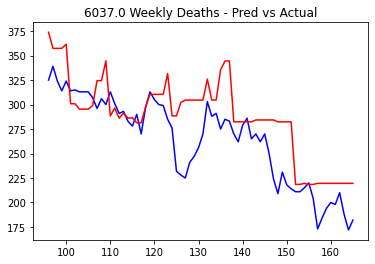

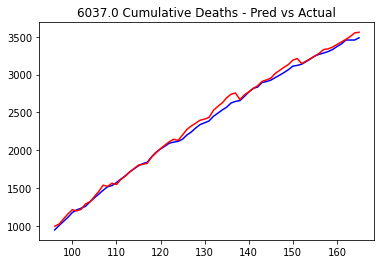

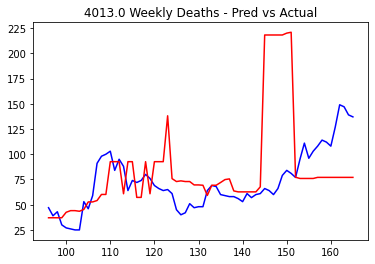

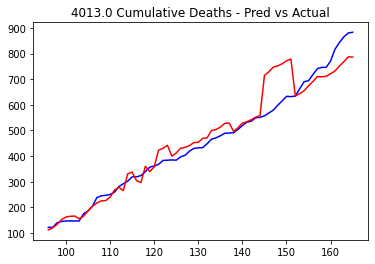

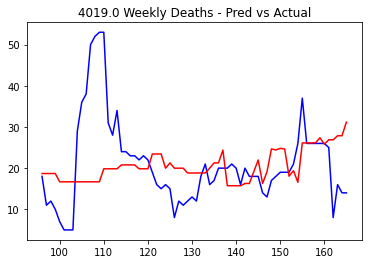

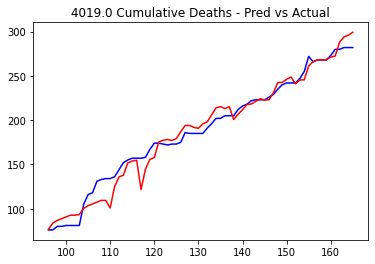

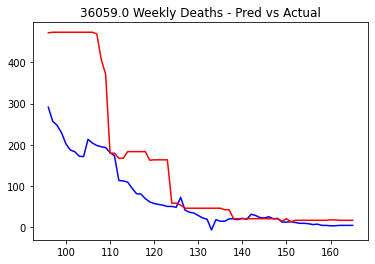

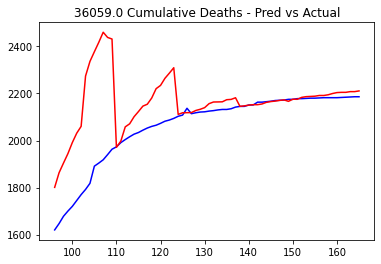

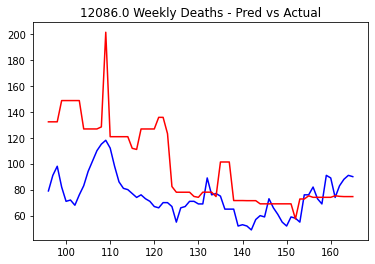

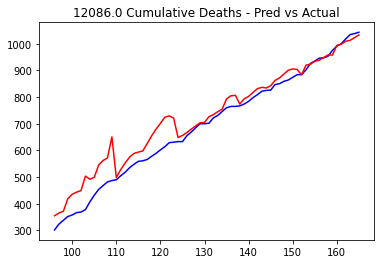

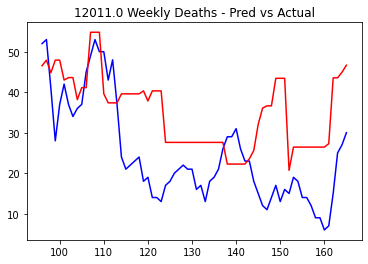

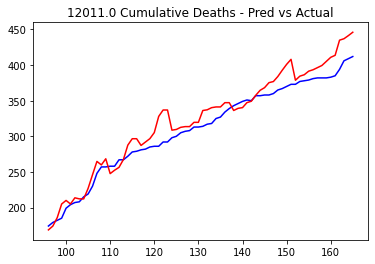

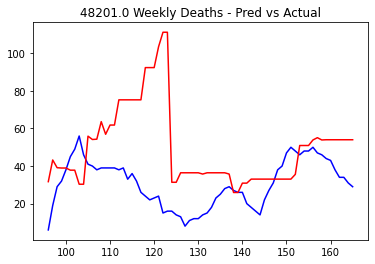

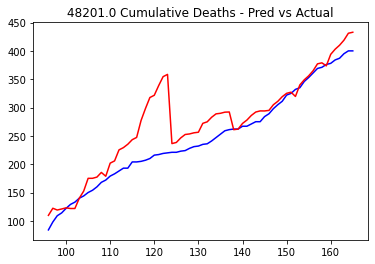

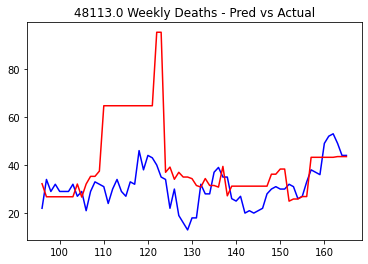

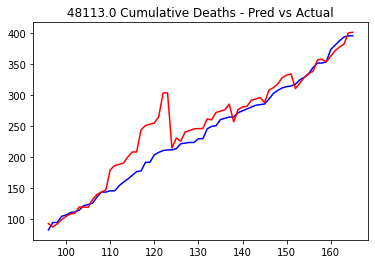

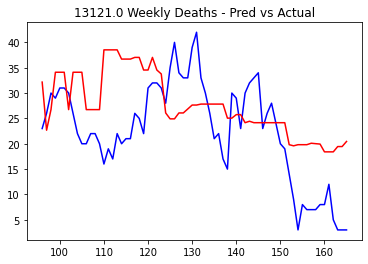

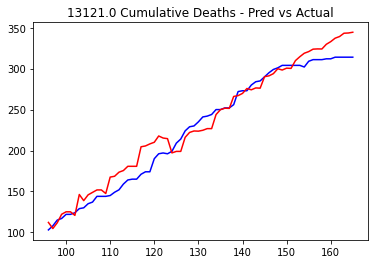

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
FIPS = [6037.0,  4013.0, 4019.0, 36059.0, 12086.0, 12011.0, 48201.0,48113.0,13121.0]

for f in FIPS:
    Deaths_Cases_df = US_Deaths_Cases_df[(US_Deaths_Cases_df["FIPS"] == f) & (US_Deaths_Cases_df["Days"] >= 96) & (US_Deaths_Cases_df["Days"] < 166)]
    predicted_df_90 = predicted_df_all_days[(predicted_df_all_days["FIPS"] == f) & (predicted_df_all_days["Days"] >= 96) & (predicted_df_all_days["Days"] < 166)]
 
    x = Deaths_Cases_df["Days"]
    z= predicted_df_90["Predicted_Weekly_Deaths"]
    y = Deaths_Cases_df["Weekly_Deaths"]
    plt.title(str(f) +" Weekly Deaths - Pred vs Actual")
    plt.plot(x, y, "-b", label="actual")
    plt.plot(x, z, "-r", label="predicted")
    plt.savefig(str(f) + "_Weekly_Deaths.png", dpi=100)   
    plt.show()
   
    x = Deaths_Cases_df["Days"]
    z= predicted_df_90["Predicted_Cumulative_Deaths"]
    y = Deaths_Cases_df["Cumulative_Deaths"]
    plt.title(str(f) +" Cumulative Deaths - Pred vs Actual")
    plt.plot(x, y, "-b", label="actual")
    plt.plot(x, z, "-r", label="predicted")
    plt.savefig(str(f) + "_X_Cumulative_Deaths.png", dpi=100)
    plt.show()
    

In [30]:
from datetime import datetime

covid_start_date = datetime.strptime("01/22/20", "%m/%d/%y")

state_predicted_deaths = predicted_df_all_days.groupby(['State', 'Days', 'Forecast_Day'], as_index=False)[["Predicted_Cumulative_Deaths"]].sum()
state_to_fips=pd.read_csv('https://docs.google.com/spreadsheets/d/1w4sHgYifJV-C8J1WV5rpTzEFLuyZ5ESp8r_1ck-9hlA/export?format=csv')
state_predicted_deaths = state_predicted_deaths.merge(state_to_fips, how='left', left_on=['State'], right_on=['Name'])
state_predicted_deaths=state_predicted_deaths.drop(columns=['Name'])
country_predicted_deaths = predicted_df_all_days.groupby(['Days', 'Forecast_Day'], as_index=False)[["Predicted_Cumulative_Deaths"]].sum()

state_predicted_deaths=state_predicted_deaths[['State','FIPS','Days','Forecast_Day','Predicted_Cumulative_Deaths']]
iteration = 0  
forecast_dates = country_predicted_deaths["Forecast_Day"].unique()
for forecast_date in forecast_dates:
  print(forecast_date)  
  covid_hub_predicted_deaths = pd.DataFrame(columns=['forecast_date','target', 'target_end_date','location', 'location_name','type', 'quantile', 'value']) 
  filename = "forecast-hub/data-processed/MIT_Sak/{}-MIT-Sak.csv".format(forecast_date)
  cp_detahs_forecast= country_predicted_deaths[country_predicted_deaths["Forecast_Day"] == forecast_date]
  for index, row in cp_detahs_forecast.iterrows():

      covid_hub_predicted_deaths.loc[iteration,"location"] = 'US'
      covid_hub_predicted_deaths.loc[iteration,"location_name"] = 'US'
      #predicted_df["FIPS"] = predict_week_df["FIPS"]
      #predicted_df["Days"] = predict_week_df["Days"]
      target_date = (covid_start_date + timedelta(days=row["Days"]))
      forecast_day =  (datetime.strptime(row["Forecast_Day"],"%Y-%m-%d") - covid_start_date).days
      days_from = str(row["Days"] - forecast_day)
      covid_hub_predicted_deaths.loc[iteration,"target"] = days_from + " day ahead cum death"
      covid_hub_predicted_deaths.loc[iteration,"target_end_date"] = target_date.strftime("%Y-%m-%d")
      covid_hub_predicted_deaths.loc[iteration,"forecast_date"] =  row["Forecast_Day"]
      covid_hub_predicted_deaths.loc[iteration,"type"] ="point"
      covid_hub_predicted_deaths.loc[iteration,"quantile"] ="NA"
      if row["Predicted_Cumulative_Deaths"] >= 0:
        covid_hub_predicted_deaths.loc[iteration,"value"] = row["Predicted_Cumulative_Deaths"]
      else:
        covid_hub_predicted_deaths.loc[iteration,"value"] = 0

      iteration = iteration + 1
  state_predicted_deaths_forecast = state_predicted_deaths[state_predicted_deaths["Forecast_Day"] == forecast_date]
  for index, row in state_predicted_deaths_forecast.iterrows():
      covid_hub_predicted_deaths.loc[iteration,"location"] = str(row["FIPS"]).zfill(2)
      covid_hub_predicted_deaths.loc[iteration,"location_name"] = row["State"]
   
      target_date = (covid_start_date + timedelta(days=row["Days"]))
      forecast_day =  (datetime.strptime(row["Forecast_Day"],"%Y-%m-%d") - covid_start_date).days
      days_from = str(row["Days"] - forecast_day)
   
      covid_hub_predicted_deaths.loc[iteration,"target"] = days_from + " day ahead cum death"
      covid_hub_predicted_deaths.loc[iteration,"target_end_date"] = target_date.strftime("%Y-%m-%d")
      covid_hub_predicted_deaths.loc[iteration,"forecast_date"] =  row["Forecast_Day"]
      covid_hub_predicted_deaths.loc[iteration,"type"] ="point"
      covid_hub_predicted_deaths.loc[iteration,"quantile"] ="NA"
      if row["Predicted_Cumulative_Deaths"] >= 0:
        covid_hub_predicted_deaths.loc[iteration,"value"] = row["Predicted_Cumulative_Deaths"]
      else:
        covid_hub_predicted_deaths.loc[iteration,"value"] = 0
      iteration = iteration + 1
  
  covid_hub_predicted_deaths.to_csv(filename,index = False)
  #files.download(filename)


2020-04-26
2020-05-10
2020-05-24
2020-06-07
2020-06-21
2020-07-05


In [31]:
import evaluate_models
from datetime import datetime
from os import listdir
from os.path import isfile, join
files = listdir('forecast-hub/data-processed/MIT_Sak')
files.sort()
for f in files :
    if f!= '.DS_Store':
        proj_date = datetime.strptime(f[:10],"%Y-%m-%d").date() +  timedelta(days=1) #Monday
        eval_date = proj_date +  timedelta(days=5) #Saturday

        print("running evaluation for proj_date: ", proj_date, " eval_date: " , eval_date)
        evaluate_models.run_evaluation('forecast-hub',proj_date, eval_date, "eval/one-week")


running evaluation for proj_date:  2020-04-27  eval_date:  2020-05-02
Forecast hub dir: forecast-hub
proj_date: 2020-04-27
eval_date: 2020-05-02
out_dir   : eval/one-week
use_point: True
use_cumulative_deaths: False
Days ahead: 5
Fetching file names from COVID-19 Forecast Hub
Auquan-SEIR - No files within range: ['2020-05-18-Auquan-SEIR.csv', '2020-05-24-Auquan-SEIR.csv', '2020-05-31-Auquan-SEIR.csv', '2020-06-07-Auquan-SEIR.csv', '2020-06-15-Auquan-SEIR.csv', '2020-06-21-Auquan-SEIR.csv', '2020-06-28-Auquan-SEIR.csv', '2020-07-05-Auquan-SEIR.csv']
CDDEP-SEIR - No files within range: ['2020-07-05-CDDEP-SEIR.csv']
COVIDhub-baseline - Found file: 2020-04-27-COVIDhub-baseline.csv
COVIDhub-ensemble - Found file: 2020-04-27-COVIDhub-ensemble.csv
CU-nochange - Found file: 2020-04-26-CU-nochange.csv
CU-scenario_high - Found file: 2020-04-26-CU-scenario_high.csv
CU-scenario_low - Found file: 2020-04-26-CU-scenario_low.csv
CU-scenario_mid - Found file: 2020-04-26-CU-scenario_mid.csv
CU-select -

Max projection date: 2020-06-20 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-05-23 - 3.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-06 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
Geneva-DetGrowth
Max projection date: 2020-05-02 - 0.7 weeks ahead
* No median data
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 14.1 weeks ahead
* No median data
Num unique locations (pre-filt) : 53
Num unique locations (

Saved to: eval/one-week/2020-05-02/projections_2020-04-27_2020-05-02.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Baseline                     -15.9     0.0     23.0     -10.7        14.7      85.7        171.1      -2.6                   8.3    -31.0    -64.7     1.4    2.3     -74.9    -86.9 -20.1     3.0   
Baseline_0.98                -18.4     0.0     19.2     -11.2        -8.2      74.5        137.9      -4.8                   4.9    -43.6    -74.3     1.3    1.8    -101.7    -97.3 -21.9     1.8   
COVIDhub-baseline            -23.0     0.0     36.0     -14.0        58.0     147.0        208.0     -11.0                  -1.0     -2.0    -36.0     1.0    5.0     -68.0    -88.0 -25.0    13.0   
COVIDhub-ensemble             -0.9     2.9     34.1       2.2        52.1

Max projection date: 2020-07-04 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-06 - 3.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-20 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
CovidActNow-SEIR_CAN
Max projection date: 2020-05-23 - 1.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
GT-DeepCOVID
Max projection date: 2020-06-08 - 4.0 weeks ahead
Num unique locations (pre-filt) : 28
Num unique locations (post-filt): 22
--------------------------

                           count  mean  median   std  min  25%   75%    max
YYG-ParamSearch             51.0  26.3    10.4  45.2  0.1  2.0  29.8  270.5
LANL-GrowthRate             51.0  31.2    10.7  54.8  0.0  4.3  26.9  260.7
Baseline_0.98               51.0  33.4    11.6  61.6  0.0  3.3  29.8  359.2
UMass-MechBayes             51.0  34.0    17.0  47.8  0.0  4.0  39.0  190.0
Baseline                    51.0  37.6    10.1  75.7  0.0  2.1  33.9  439.9
UT-Mobility                 51.0  38.6    15.7  68.3  0.7  4.5  34.1  354.6
COVIDhub-ensemble           51.0  39.0    13.9  89.9  0.1  4.9  31.9  495.8
CU-select                   51.0  50.6    30.0  66.2  0.0  6.5  55.5  308.0
COVIDhub-baseline           51.0  61.9    14.0 171.5  0.0  7.0  45.0 1168.0
UCLA-SuEIR                  51.0  66.0    23.2 179.7  0.5  5.2  57.1 1242.0
MOBS_NEU-GLEAM_COVID        51.0  79.4    16.7 217.2  0.6  5.7  63.3 1475.9
IHME-CurveFit               51.0  81.0    16.2 184.8  0.5  5.0  65.9  987.7
MIT_CovidAna

Max projection date: 2020-07-18 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-20 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-22 - 4.0 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-10-10 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
-----------------------------
GT-DeepCOVID
Max projection date: 2020-06-22 - 4.0 weeks ahead
Num unique locations (pre-filt) : 38
Num unique locations (post-filt): 31
-----------------------------
Geneva-DetGrowth
Max proje

Saved to: eval/one-week/2020-05-30/projections_2020-05-25_2020-05-30.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana   Iowa  Kansas  \
Auquan-SEIR                  185.0     5.0    102.0      37.0       607.0     230.0        154.0      81.0                  78.0    325.0    170.0     8.0   24.0    1100.0    383.0   94.0    95.0   
Baseline                     -13.0     0.0      0.7      -1.6        49.6     -10.7         25.3      -4.1                  12.0     16.3      9.0     0.0    2.1     108.0     43.9   15.0    -1.4   
Baseline_0.98                -15.6     0.0     -4.3      -2.3        28.1     -15.6         13.4      -5.6                  10.0      5.3     -0.1     0.0    1.9      79.7     34.5   10.6    -1.8   
COVIDhub-baseline             -5.0     0.0     19.0      -1.0       1

Max projection date: 2020-08-01 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-04 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-06 - 4.0 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-10-24 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
-----------------------------
CovidActNow-SEIR_CAN
Max projection date: 2020-07-04 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
------

Saved to: eval/one-week/2020-06-13/projections_2020-06-08_2020-06-13.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR                  133.0     2.0    193.0      70.0       839.0     231.0        344.0      73.0                  60.0    697.0    355.0     5.0   20.0    1028.0    290.0 305.0    71.0   
Baseline                     -27.9    -2.0    -14.6      -5.0       -49.7       0.3         -6.1       6.4                  -2.3    -11.6   -158.1     0.0   -3.1      55.6     34.9  15.0     3.4   
Baseline_0.98                -30.4    -2.0    -20.6      -5.9       -68.9      -3.1        -11.4       5.1                  -3.2    -22.0   -163.4     0.0   -3.2      34.1     27.8  12.1     2.7   
COVIDhub-baseline            -13.0    -2.0     -7.0      -2.0        -8.0

Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-07-18 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-baseline
Max projection date: 2020-08-15 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-18 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-20 - 4.0 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-11-07 - 19.7 weeks ahead
Num unique loca

Saved to: eval/one-week/2020-06-27/2020-06-22_2020-06-27_us_errs.csv
State-by-state Evaluation:
Number of states with valid projections:
Auquan-SEIR                  51
Baseline                     51
Baseline_0.98                51
COVIDhub-baseline            51
COVIDhub-ensemble            51
CU-select                    51
Covid19Sim-Simulator         51
CovidActNow-SEIR_CAN         43
IHME-CurveFit                51
IowaStateLW-STEM             49
JHU_IDD-CovidSP              51
LANL-GrowthRate              51
MIT_CovidAnalytics-DELPHI    51
MIT_Sak                      49
MOBS_NEU-GLEAM_COVID         50
NotreDame-mobility           51
OliverWyman-Navigator        51
PSI-DRAFT                    51
UA-EpiCovDA                  51
UCLA-SuEIR                   51
UMass-MechBayes              51
USACE-ERDC_SEIR              51
UT-Mobility                  51
YYG-ParamSearch              51
dtype: int64
------------------------
Cumulative death forecasts for 2020-06-27:
              

                           count     mean  median       std  min   25%     75%        max
IowaStateLW-STEM            51.0  57235.9   676.0  355296.2  0.0  25.0  2917.0  2537649.0
Auquan-SEIR                 51.0  58246.3   169.0  358801.8  0.0  16.0  2164.5  2556801.0
COVIDhub-baseline           51.0  58918.4   100.0  414623.1  0.0  20.5  1300.0  2961841.0
UCLA-SuEIR                  51.0  61458.3    90.6  434469.0  0.0  11.6   850.8  3103342.1
UT-Mobility                 51.0  61488.7   100.0  429144.5  0.0   6.5  1124.5  3066001.0
Baseline                    51.0  62127.2   124.2  438091.7  0.1   3.2   692.2  3129361.0
Baseline_0.98               51.0  62947.4    94.6  443899.0  0.1   7.7   686.9  3170838.2
COVIDhub-ensemble           51.0  63332.6    37.2  445191.1  0.0   4.0   949.6  3180241.5
MOBS_NEU-GLEAM_COVID        51.0  65618.7   170.6  457609.4  0.2  24.8  1377.5  3269449.2
LANL-GrowthRate             51.0  65690.8   181.2  445376.0  0.1  13.3  2743.3  3183348.7
UMass-Mech

Max projection date: 2020-08-29 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-08-01 - 3.7 weeks ahead
Num unique locations (pre-filt) : 57
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-08-15 - 5.7 weeks ahead
Num unique locations (pre-filt) : 3192
Num unique locations (post-filt): 52
-----------------------------
Columbia_UNC-SurvCon
Max projection date: 2020-08-29 - 7.7 weeks ahead
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-11-21 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
------

                           count      mean  median       std  min   25%     75%        max
COVIDhub-ensemble           51.0    2835.7   115.1    9579.2  0.1   6.5   636.4    58686.2
USC-SI_kJalpha              51.0    3486.0   109.9   13083.5  0.0   7.8   780.9    83220.1
UMass-MechBayes             51.0    4190.9   121.0   13528.3  0.0   4.0   485.0    65025.0
OliverWyman-Navigator       51.0    4257.5    68.0   14703.5  0.1   8.7   392.0    72714.4
USACE-ERDC_SEIR             51.0    4395.2   104.8   12812.8  0.0  24.1  1252.7    64483.5
UCLA-SuEIR                  51.0    4855.2   139.0   16628.6  0.0  36.4  1310.3    92367.5
LANL-GrowthRate             51.0    4998.0    89.0   23003.6  0.0   4.5   567.0   162226.5
UT-Mobility                 51.0    5010.5   121.0   13400.3  0.0  16.0  2682.5    65025.0
COVIDhub-baseline           51.0    5331.5    81.0   16967.1  0.0  17.0   962.0    89401.0
MOBS_NEU-GLEAM_COVID        51.0    5604.6   314.9   15530.5  0.0  21.0  1859.0    73123.6

In [32]:
for f in files :
    if f!= '.DS_Store':
        proj_date = datetime.strptime(f[:10],"%Y-%m-%d").date() +  timedelta(days=1) #Monday
        eval_date = proj_date +  timedelta(days=12) #Saturday

        print("running evaluation for proj_date: ", proj_date, " eval_date: " , eval_date)
        evaluate_models.run_evaluation('forecast-hub',proj_date, eval_date, "eval/two-weeks")

running evaluation for proj_date:  2020-04-27  eval_date:  2020-05-09
Forecast hub dir: forecast-hub
proj_date: 2020-04-27
eval_date: 2020-05-09
out_dir   : eval/two-weeks
use_point: True
use_cumulative_deaths: False
Days ahead: 12
Fetching file names from COVID-19 Forecast Hub
Auquan-SEIR - No files within range: ['2020-05-18-Auquan-SEIR.csv', '2020-05-24-Auquan-SEIR.csv', '2020-05-31-Auquan-SEIR.csv', '2020-06-07-Auquan-SEIR.csv', '2020-06-15-Auquan-SEIR.csv', '2020-06-21-Auquan-SEIR.csv', '2020-06-28-Auquan-SEIR.csv', '2020-07-05-Auquan-SEIR.csv']
CDDEP-SEIR - No files within range: ['2020-07-05-CDDEP-SEIR.csv']
COVIDhub-baseline - Found file: 2020-04-27-COVIDhub-baseline.csv
COVIDhub-ensemble - Found file: 2020-04-27-COVIDhub-ensemble.csv
CU-nochange - Found file: 2020-04-26-CU-nochange.csv
CU-scenario_high - Found file: 2020-04-26-CU-scenario_high.csv
CU-scenario_low - Found file: 2020-04-26-CU-scenario_low.csv
CU-scenario_mid - Found file: 2020-04-26-CU-scenario_mid.csv
CU-select

Max projection date: 2020-06-20 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-05-23 - 3.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-06 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
Geneva-DetGrowth
Max projection date: 2020-05-02 - 0.7 weeks ahead
* No point data
* No median data
Num unique locations (pre-filt) : 0
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 14.1 weeks ahead
* No median data
Num unique 

Incident US deaths: 17291
Loading model projections
-----------------------------
COVIDhub-baseline
Max projection date: 2020-07-04 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-06 - 3.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-20 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
CovidActNow-SEIR_CAN
Max projection date: 2020-05-23 - 1.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
GT-DeepCOVID
Max projection date: 2020-06-08 - 4.0 weeks ahead


------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana   Iowa  Kansas  \
Baseline                      35.3     1.9     58.1       3.9       -92.4    -116.4        278.1     -19.3                  29.7    123.1     -3.7     0.0   -6.4      79.4    242.3  -30.6    24.7   
Baseline_0.98                 13.9     1.6     22.1       0.7      -196.1    -143.2        168.1     -28.4                  14.8     52.2    -49.7     0.0   -7.1     -83.9    164.3  -47.4    18.5   
COVIDhub-baseline             45.0     2.0    135.0       5.0       -36.0     -90.0        249.0       5.0                  26.0    184.0     33.0     2.3   -5.9     139.0    276.0  -40.0    33.0   
COVIDhub-ensemble             11.7     2.1    -25.8       6.8      -145.6     -82.3         27.8      -9.9                  34.7     15.3    -

Max projection date: 2020-07-18 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-20 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-22 - 4.0 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-10-10 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
-----------------------------
GT-DeepCOVID
Max projection date: 2020-06-22 - 4.0 weeks ahead
Num unique locations (pre-filt) : 38
Num unique locations (post-filt): 31
-----------------------------
Geneva-DetGrowth
Max proje

YYG-ParamSearch                  -2.5           -1.0      -49.7     -1.0  
----------------------
States - mean squared errors:
                           count     mean  median       std  min    25%      75%        max
UMass-MechBayes             51.0   1552.2   196.0    4848.4  0.0    4.0   1122.5    31329.0
COVIDhub-ensemble           51.0   5537.0   247.5   13339.8  0.1   19.5   3750.8    68167.0
UCLA-SuEIR                  51.0   7994.5   155.3   22199.9  0.1   18.9   3432.4   119641.6
Baseline_0.98               51.0   8057.8   167.9   25811.8  0.0   23.6   1736.4   145698.4
YYG-ParamSearch             51.0   8329.0   237.4   20759.5  0.4    8.5   2309.9    85388.4
LANL-GrowthRate             51.0   8512.1   403.2   32821.5  0.0   38.1   3477.4   228141.9
UT-Mobility                 51.0   9789.0   289.0   29751.3  0.0   17.0   3978.0   189225.0
MOBS_NEU-GLEAM_COVID        51.0  13874.9   549.3   41316.9  0.2   27.9   3503.1   260462.1
MIT_CovidAnalytics-DELPHI   51.0  15256.0   

Max projection date: 2020-08-01 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-04 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-06 - 4.0 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-10-24 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
-----------------------------
CovidActNow-SEIR_CAN
Max projection date: 2020-07-04 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
------

Saved to: eval/two-weeks/2020-06-20/projections_2020-06-08_2020-06-20.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR                  243.0     5.0    321.0     119.0      1768.0     403.0        620.0     143.0                 107.0   1547.0    618.0     9.0   37.0    1879.0    593.0 530.0   122.0   
Baseline                     -30.9    -2.0    -27.6     -31.0        -7.7      32.3         55.9      23.4                   0.7     18.4   -226.1     0.0   -4.1     233.6     80.9  54.0    10.4   
Baseline_0.98                -43.7    -2.0    -57.4     -35.4      -103.1      15.3         29.5      16.8                  -4.1    -33.2   -252.5     0.0   -4.4     127.0     45.8  39.5     6.7   
COVIDhub-baseline             -7.0    -2.0    -25.0     -28.0        36.

UChicago-CovidIL_100 - No files within range: ['2020-05-05-UChicago-CovidIL_100.csv', '2020-05-11-UChicago-CovidIL_100.csv', '2020-05-18-UChicago-CovidIL_100.csv']
UChicago-CovidIL_10_increase - No files within range: ['2020-05-18-UChicago-CovidIL_10_increase.csv']
UChicago-CovidIL_30_increase - No files within range: ['2020-05-18-UChicago-CovidIL_30_increase.csv']
UChicago-CovidIL_40 - No files within range: ['2020-05-05-UChicago-CovidIL_40.csv', '2020-05-11-UChicago-CovidIL_40.csv']
UChicago-CovidIL_60 - No files within range: ['2020-05-05-UChicago-CovidIL_60.csv', '2020-05-11-UChicago-CovidIL_60.csv']
UChicago-CovidIL_80 - No files within range: ['2020-05-05-UChicago-CovidIL_80.csv', '2020-05-11-UChicago-CovidIL_80.csv']
UM_CFG-RidgeTfReg - No files within range: ['2020-07-06-UM_CFG-RidgeTfReg.csv']
UMass-ExpertCrowd - No files within range: ['2020-04-13-UMass-ExpertCrowd.csv', '2020-04-20-UMass-ExpertCrowd.csv']
UMass-MechBayes - Found file: 2020-06-21-UMass-MechBayes.csv
USACE-ERD

------------------------
Cumulative death forecasts for 2020-07-04:
                      actual_deaths  Baseline  Baseline_0.98  Auquan-SEIR  COVIDhub-baseline  COVIDhub-ensemble  CU-select  Covid19Sim-Simulator  CovidActNow-SEIR_CAN  GT-DeepCOVID  GT_CHHS-COVID19  \
Alabama                      1007.0     961.6          947.9        983.0              968.0             1009.5     1242.0                1023.1                1127.6        1026.4              nan   
Alaska                         16.0      12.0           12.0         15.0               12.0               13.3       12.0                  14.4                  31.1          14.2              nan   
Arizona                      1817.0    1642.4         1609.7       1823.0             1660.0             1888.3     2860.0                2076.7                   nan           nan              nan   
Arkansas                      286.0     310.4          300.9        311.0              318.0              320.0      496.0      

                           count     mean  median       std  min   25%     75%        max
COVIDhub-baseline           51.0  59613.9   529.0  384839.1  0.0  21.1  5712.7  2752479.0
IowaStateLW-STEM            51.0  62519.1   961.0  354171.3  0.0  42.5  8586.5  2521744.0
Baseline                    51.0  63327.2   792.0  418572.8  0.1  19.1  3889.0  2992900.0
UT-Mobility                 51.0  63676.3   900.0  421981.5  0.0  56.5  4972.5  3017169.0
UCLA-SuEIR                  51.0  64307.5   362.5  441225.9  0.4  26.5  3222.1  3153356.4
Baseline_0.98               51.0  66813.6   499.1  447184.5  0.5  33.7  3673.0  3197104.1
Auquan-SEIR                 51.0  67071.9   576.0  341299.9  0.0  49.0  4850.5  2362369.0
COVIDhub-ensemble           51.0  70521.0   494.3  465942.8  0.0  16.6  3839.4  3331114.1
YYG-ParamSearch             51.0  75277.0   138.5  519766.3  0.2  17.4  1645.1  3714147.5
LANL-GrowthRate             51.0  77660.3  1035.3  467999.0  0.2  26.3 10528.8  3344198.9
MOBS_NEU-G

KeyError: 'US'